# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                      
Sample_134  E5RIP7;H0YBL1;P29218;P29218-3          16.908
Sample_129  Q08380                                 20.274
Sample_060  G3V3X5;G3V511;Q14767                   16.664
Sample_056  P05160                                 14.445
Sample_158  A6XND0;A6XND1;B3KWK7;P17936;P17936-2   17.053
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups                            
Sample_037  Q6P4E1;Q6P4E1-4;Q6P4E1-5                     17.023
Sample_109  P05556;P05556-2;P05556-3;P05556-4;P05556-5   11.212
Sample_110  Q8IUC8                                       15.598
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.819
            A0A075B6Q5                 12.608
            A0A075B6R2                 11.505
            A0A075B6S5                 13.259
            A0A087WSY4                 13.354
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.517
            Q9UI40;Q9UI40-2            11.384
            Q9UIW2                     11.896
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.612
            Q9UP79                     13.872
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.296,15.050,16.842,19.863,15.888,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.784,19.067,...,15.528,15.576,14.014,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.838,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.265,17.705,17.039,15.886,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.561,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.384,15.345,17.084,18.708,14.249,19.433,11.458,11.157
Sample_207,15.739,16.877,15.469,16.898,15.198,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.819,...,16.012,15.178,12.394,15.050,16.842,19.863,12.920,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.989,19.067,16.188,...,15.528,15.576,14.506,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.212,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.986,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.019,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.337,15.345,17.084,18.708,14.249,19.433,12.764,13.320
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 357.88it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.62it/s]

100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.97it/s]

100%|██████████| 3/3 [00:00<00:00,  4.06it/s]

100%|██████████| 3/3 [00:00<00:00,  4.32it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.11it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.58it/s]

100%|██████████| 4/4 [00:01<00:00,  2.13it/s]

100%|██████████| 4/4 [00:01<00:00,  2.29it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.23it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.51it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.99it/s]

100%|██████████| 5/5 [00:01<00:00,  3.70it/s]

100%|██████████| 5/5 [00:01<00:00,  4.04it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.30it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.46it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.94it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.04it/s]

100%|██████████| 6/6 [00:01<00:00,  2.99it/s]

100%|██████████| 6/6 [00:01<00:00,  3.16it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.36it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.92it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.89it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.64it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.25it/s]

100%|██████████| 7/7 [00:02<00:00,  1.95it/s]

100%|██████████| 7/7 [00:02<00:00,  2.34it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.79it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.51it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.31it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.09it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.93it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.94it/s]

100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

100%|██████████| 8/8 [00:03<00:00,  2.14it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.47it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.49it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.02it/s]

 56%|█████▌    | 5/9 [00:02<00:02,  1.89it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.85it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.95it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.08it/s]

100%|██████████| 9/9 [00:04<00:00,  2.27it/s]

100%|██████████| 9/9 [00:04<00:00,  2.16it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.68it/s]

 30%|███       | 3/10 [00:00<00:02,  3.38it/s]

 40%|████      | 4/10 [00:01<00:01,  3.02it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.97it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.89it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.86it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.77it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.61it/s]

100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

100%|██████████| 10/10 [00:03<00:00,  2.84it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.31it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.89it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.94it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.47it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.28it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.17it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.31it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.39it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.25it/s]

100%|██████████| 11/11 [00:04<00:00,  1.96it/s]

100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.11it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.59it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.34it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.71it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.40it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.13it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.23it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.16it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.40it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.55it/s]

100%|██████████| 12/12 [00:04<00:00,  2.47it/s]

100%|██████████| 12/12 [00:04<00:00,  2.54it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.83it/s]

 23%|██▎       | 3/13 [00:01<00:03,  2.52it/s]

 31%|███       | 4/13 [00:01<00:03,  2.34it/s]

 38%|███▊      | 5/13 [00:02<00:03,  2.31it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.49it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.63it/s]

 62%|██████▏   | 8/13 [00:03<00:01,  2.63it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.62it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.41it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.12it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.03it/s]

100%|██████████| 13/13 [00:05<00:00,  2.11it/s]

100%|██████████| 13/13 [00:05<00:00,  2.35it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.20it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.28it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.29it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.11it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.94it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.78it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.35it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.33it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.29it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.34it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.12it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  1.92it/s]

100%|██████████| 14/14 [00:05<00:00,  1.83it/s]

100%|██████████| 14/14 [00:05<00:00,  2.37it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.99it/s]

 20%|██        | 3/15 [00:00<00:03,  3.55it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.21it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.26it/s]

 40%|████      | 6/15 [00:01<00:03,  2.67it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.33it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.08it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.96it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.87it/s]

 73%|███████▎  | 11/15 [00:04<00:02,  1.85it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.00it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.13it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.37it/s]

100%|██████████| 15/15 [00:06<00:00,  2.42it/s]

100%|██████████| 15/15 [00:06<00:00,  2.37it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.007      0.065 0.027          0.793 0.319       0.124   
2             0.006 0.005      0.076 0.032          0.756 0.092       0.714   
3             0.004 0.001      0.049 0.020          0.749 0.092       0.712   
4             0.006 0.006      0.093 0.037          0.786 0.100       0.778   
5             0.009 0.008      0.096 0.037          0.778 0.096       0.776   
6             0.006 0.004      0.074 0.025          0.809 0.091       0.802   
7             0.005 0.004      0.065 0.029          0.811 0.089       0.807   
8             0.005 0.004      0.055 0.018          0.808 0.081       0.802   
9             0.006 0.005      0.073 0.027          0.806 0.079       0.794   
10            0.008 0.007      0.088 0.028          0.806 0.085       0.793   
11            0.007 0.006      0.079 0.032          0.802 0.085       0.796   
12            0.007 0.006      0.076 0.029          0.796 0.084       0.789   
13            0.008 0.008      0.080 0.027          0.790 0.084       0.786   
14            0.007 0.006      0.084 0.034          0.802 0.078       0.783   
15            0.006 0.005      0.084 0.033          0.809 0.090       0.786   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.207 0.121                  0.554 0.039        0.855   
2          0.100   0.726 0.060                  0.768 0.047        0.861   
3          0.092   0.725 0.070                  0.766 0.057        0.860   
4          0.094   0.777 0.074                  0.809 0.063        0.894   
5          0.091   0.772 0.068                  0.804 0.058        0.898   
6          0.097   0.800 0.069                  0.829 0.058        0.914   
7          0.097   0.804 0.068                  0.832 0.058        0.912   
8          0.095   0.801 0.066                  0.830 0.056        0.911   
9          0.097   0.796 0.069                  0.826 0.058        0.910   
10         0.097   0.795 0.071                  0.825 0.060        0.908   
11         0.103   0.795 0.074                  0.825 0.062        0.907   
12         0.102   0.788 0.073                  0.819 0.061        0.905   
13         0.098   0.783 0.071                  0.815 0.060        0.904   
14         0.097   0.788 0.068                  0.820 0.057        0.906   
15         0.092   0.793 0.069                  0.823 0.057        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.824 0.091        210.000 0.000  
2          0.056                  0.837 0.066        210.000 0.000  
3          0.053                  0.839 0.061        210.000 0.000  
4          0.049                  0.877 0.058        210.000 0.000  
5          0.047                  0.882 0.052        210.000 0.000  
6          0.046                  0.899 0.052        210.000 0.000  
7          0.049                  0.897 0.054        210.000 0.000  
8          0.049                  0.897 0.054        210.000 0.000  
9          0.049                  0.896 0.054        210.000 0.000  
10         0.049                  0.894 0.054        210.000 0.000  
11         0.050                  0.893 0.055        210.000 0.000  
12         0.050                  0.890 0.056        210.000 0.000  
13         0.050                  0.890 0.054        210.000 0.000  
14         0.050                  0.890 0.055        210.000 0.000  
15         0.047                  0.894 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 456.40it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.50it/s]

100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.25it/s]

100%|██████████| 3/3 [00:01<00:00,  2.45it/s]

100%|██████████| 3/3 [00:01<00:00,  2.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.59it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.65it/s]

100%|██████████| 4/4 [00:01<00:00,  3.05it/s]

100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:01,  2.83it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.05it/s]

 80%|████████  | 4/5 [00:01<00:00,  1.92it/s]

100%|██████████| 5/5 [00:02<00:00,  2.02it/s]

100%|██████████| 5/5 [00:02<00:00,  2.08it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  4.79it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.12it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.85it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.61it/s]

100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

100%|██████████| 6/6 [00:02<00:00,  2.60it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.17it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.63it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.10it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.82it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.60it/s]

100%|██████████| 7/7 [00:03<00:00,  1.62it/s]

100%|██████████| 7/7 [00:03<00:00,  1.87it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:02,  2.83it/s]

 38%|███▊      | 3/8 [00:01<00:02,  1.96it/s]

 50%|█████     | 4/8 [00:01<00:02,  1.97it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.92it/s]

 75%|███████▌  | 6/8 [00:03<00:01,  1.90it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.93it/s]

100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.93it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.23it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.76it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.42it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.53it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.53it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.52it/s]

100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.39it/s]

 30%|███       | 3/10 [00:00<00:02,  2.92it/s]

 40%|████      | 4/10 [00:01<00:02,  2.82it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.78it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.80it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.72it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.77it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.82it/s]

100%|██████████| 10/10 [00:03<00:00,  2.64it/s]

100%|██████████| 10/10 [00:03<00:00,  2.79it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.27it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.81it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.41it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.22it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.13it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.99it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.86it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.67it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.05it/s]

100%|██████████| 11/11 [00:04<00:00,  1.78it/s]

100%|██████████| 11/11 [00:04<00:00,  2.48it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.53it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.03it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.40it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.16it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.94it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.92it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.31it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  1.93it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.85it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.85it/s]

100%|██████████| 12/12 [00:05<00:00,  1.91it/s]

100%|██████████| 12/12 [00:05<00:00,  2.34it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.42it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.02it/s]

 31%|███       | 4/13 [00:01<00:02,  3.49it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.25it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.81it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.28it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.83it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.65it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.81it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.01it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.09it/s]

100%|██████████| 13/13 [00:05<00:00,  2.14it/s]

100%|██████████| 13/13 [00:05<00:00,  2.29it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.23it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.74it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.01it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.33it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.03it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.77it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.85it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.94it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.07it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.15it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.21it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.24it/s]

100%|██████████| 14/14 [00:06<00:00,  2.32it/s]

100%|██████████| 14/14 [00:06<00:00,  2.26it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.80it/s]

 20%|██        | 3/15 [00:00<00:03,  3.30it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.40it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.13it/s]

 40%|████      | 6/15 [00:02<00:04,  1.93it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.83it/s]

 53%|█████▎    | 8/15 [00:03<00:04,  1.75it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.82it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.91it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.06it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.15it/s]

 87%|████████▋ | 13/15 [00:06<00:00,  2.21it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.28it/s]

100%|██████████| 15/15 [00:06<00:00,  2.28it/s]

100%|██████████| 15/15 [00:06<00:00,  2.17it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.008 0.006      0.093 0.035          0.087 0.248       0.009   
2             0.004 0.002      0.059 0.019          0.666 0.117       0.517   
3             0.006 0.005      0.085 0.043          0.807 0.078       0.713   
4             0.006 0.005      0.075 0.030          0.797 0.089       0.719   
5             0.007 0.006      0.080 0.027          0.787 0.089       0.709   
6             0.007 0.007      0.086 0.042          0.802 0.092       0.783   
7             0.007 0.006      0.071 0.027          0.790 0.094       0.794   
8             0.004 0.002      0.057 0.019          0.793 0.097       0.788   
9             0.005 0.004      0.070 0.027          0.797 0.095       0.790   
10            0.007 0.006      0.070 0.029          0.792 0.100       0.762   
11            0.006 0.005      0.063 0.021          0.826 0.092       0.790   
12            0.006 0.005      0.059 0.021          0.825 0.093       0.795   
13            0.005 0.003      0.061 0.023          0.845 0.091       0.799   
14            0.005 0.003      0.061 0.026          0.843 0.089       0.795   
15            0.007 0.005      0.069 0.022          0.823 0.092       0.784   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.860   
2          0.122   0.573 0.098                  0.661 0.067        0.742   
3          0.103   0.753 0.080                  0.794 0.060        0.871   
4          0.113   0.751 0.084                  0.792 0.065        0.872   
5          0.118   0.740 0.083                  0.783 0.065        0.872   
6          0.107   0.787 0.075                  0.819 0.061        0.898   
7          0.102   0.787 0.072                  0.818 0.061        0.900   
8          0.114   0.785 0.082                  0.817 0.068        0.898   
9          0.108   0.788 0.077                  0.819 0.064        0.896   
10         0.113   0.771 0.082                  0.805 0.068        0.905   
11         0.113   0.803 0.082                  0.833 0.068        0.919   
12         0.113   0.804 0.082                  0.834 0.068        0.918   
13         0.102   0.817 0.077                  0.845 0.064        0.920   
14         0.109   0.813 0.078                  0.842 0.064        0.919   
15         0.114   0.798 0.083                  0.829 0.068        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.826 0.087        210.000 0.000  
2          0.077                  0.679 0.100        210.000 0.000  
3          0.052                  0.826 0.073        210.000 0.000  
4          0.052                  0.831 0.072        210.000 0.000  
5          0.053                  0.829 0.073        210.000 0.000  
6          0.050                  0.871 0.066        210.000 0.000  
7          0.050                  0.872 0.064        210.000 0.000  
8          0.053                  0.872 0.066        210.000 0.000  
9          0.053                  0.869 0.067        210.000 0.000  
10         0.048                  0.881 0.059        210.000 0.000  
11         0.045                  0.899 0.055        210.000 0.000  
12         0.045                  0.897 0.058        210.000 0.000  
13         0.045                  0.899 0.056        210.000 0.000  
14         0.045                  0.897 0.056        210.000 0.000  
15         0.044                  0.899 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 995.09it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 16.70it/s]

100%|██████████| 2/2 [00:00<00:00, 15.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 18.38it/s]

100%|██████████| 3/3 [00:00<00:00, 12.61it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 14.16it/s]

100%|██████████| 4/4 [00:00<00:00, 12.04it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.78it/s]

100%|██████████| 5/5 [00:00<00:00, 14.24it/s]

100%|██████████| 5/5 [00:00<00:00, 14.52it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 29.50it/s]

100%|██████████| 6/6 [00:00<00:00, 26.44it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 18.21it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.97it/s]

100%|██████████| 7/7 [00:00<00:00, 14.08it/s]

100%|██████████| 7/7 [00:00<00:00, 14.58it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 21.60it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 15.12it/s]

100%|██████████| 8/8 [00:00<00:00, 14.67it/s]

100%|██████████| 8/8 [00:00<00:00, 15.23it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.72it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 15.94it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 13.35it/s]

100%|██████████| 9/9 [00:00<00:00, 11.66it/s]

100%|██████████| 9/9 [00:00<00:00, 12.91it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 14.52it/s]

 50%|█████     | 5/10 [00:00<00:00, 11.62it/s]

 70%|███████   | 7/10 [00:00<00:00, 10.60it/s]

 90%|█████████ | 9/10 [00:00<00:00,  9.42it/s]

100%|██████████| 10/10 [00:01<00:00,  9.15it/s]

100%|██████████| 10/10 [00:01<00:00,  9.98it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 18.28it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.94it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.71it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.69it/s]

100%|██████████| 11/11 [00:00<00:00, 10.42it/s]

100%|██████████| 11/11 [00:00<00:00, 11.27it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 18.07it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.81it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.84it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.62it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 11.70it/s]

100%|██████████| 12/12 [00:00<00:00, 12.37it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.56it/s]

 46%|████▌     | 6/13 [00:00<00:00, 13.98it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 13.20it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 13.14it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 12.80it/s]

100%|██████████| 13/13 [00:00<00:00, 13.40it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.95it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.98it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.99it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.23it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.94it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 12.48it/s]

100%|██████████| 14/14 [00:01<00:00, 13.14it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.26it/s]

 27%|██▋       | 4/15 [00:00<00:00, 14.33it/s]

 40%|████      | 6/15 [00:00<00:00, 11.35it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 11.53it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 11.35it/s]

 80%|████████  | 12/15 [00:01<00:00, 11.57it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 11.26it/s]

100%|██████████| 15/15 [00:01<00:00, 11.71it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.009      0.078 0.032          0.000 0.000       0.000   
2             0.005 0.004      0.086 0.036          0.618 0.134       0.424   
3             0.007 0.007      0.079 0.037          0.637 0.088       0.538   
4             0.005 0.004      0.064 0.023          0.645 0.080       0.559   
5             0.003 0.001      0.046 0.021          0.660 0.080       0.630   
6             0.003 0.001      0.033 0.008          0.645 0.085       0.608   
7             0.004 0.002      0.045 0.012          0.681 0.086       0.620   
8             0.004 0.000      0.048 0.005          0.684 0.094       0.626   
9             0.006 0.005      0.063 0.021          0.678 0.092       0.631   
10            0.004 0.002      0.053 0.014          0.692 0.095       0.647   
11            0.005 0.002      0.059 0.020          0.693 0.095       0.661   
12            0.005 0.003      0.063 0.024          0.691 0.092       0.659   
13            0.006 0.004      0.062 0.021          0.685 0.090       0.662   
14            0.006 0.005      0.062 0.022          0.684 0.093       0.660   
15            0.006 0.004      0.066 0.023          0.668 0.088       0.642   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.752   
2          0.101   0.496 0.099                  0.613 0.067        0.708   
3          0.099   0.578 0.078                  0.656 0.058        0.767   
4          0.104   0.594 0.081                  0.667 0.058        0.780   
5          0.128   0.640 0.096                  0.698 0.071        0.795   
6          0.119   0.619 0.083                  0.680 0.063        0.799   
7          0.112   0.643 0.084                  0.703 0.065        0.801   
8          0.123   0.647 0.091                  0.706 0.071        0.802   
9          0.127   0.647 0.093                  0.705 0.071        0.802   
10         0.118   0.664 0.093                  0.717 0.074        0.807   
11         0.118   0.671 0.090                  0.722 0.073        0.806   
12         0.118   0.670 0.091                  0.721 0.074        0.806   
13         0.120   0.668 0.090                  0.719 0.073        0.802   
14         0.122   0.667 0.093                  0.718 0.075        0.801   
15         0.127   0.649 0.096                  0.704 0.072        0.805   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.692 0.084        210.000 0.000  
2          0.076                  0.649 0.089        210.000 0.000  
3          0.058                  0.707 0.072        210.000 0.000  
4          0.059                  0.711 0.076        210.000 0.000  
5          0.061                  0.732 0.079        210.000 0.000  
6          0.062                  0.743 0.080        210.000 0.000  
7          0.063                  0.745 0.080        210.000 0.000  
8          0.063                  0.752 0.079        210.000 0.000  
9          0.065                  0.750 0.080        210.000 0.000  
10         0.065                  0.754 0.083        210.000 0.000  
11         0.065                  0.741 0.088        210.000 0.000  
12         0.066                  0.737 0.090        210.000 0.000  
13         0.066                  0.733 0.090        210.000 0.000  
14         0.065                  0.732 0.090        210.000 0.000  
15         0.062                  0.740 0.086 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,5,1,1
score_time,5,1,2
test_precision,7,13,11
test_recall,7,13,13
test_f1,7,13,11
test_balanced_accuracy,7,13,11
test_roc_auc,6,13,10
test_average_precision,6,11,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.25it/s]

 23%|██▎       | 3/13 [00:00<00:03,  3.30it/s]

 31%|███       | 4/13 [00:01<00:02,  3.11it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.85it/s]

 46%|████▌     | 6/13 [00:02<00:02,  2.63it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.61it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.71it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.37it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.25it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.23it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.11it/s]

100%|██████████| 13/13 [00:05<00:00,  2.13it/s]

100%|██████████| 13/13 [00:05<00:00,  2.48it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 19.31it/s]

 40%|████      | 4/10 [00:00<00:00, 12.77it/s]

 60%|██████    | 6/10 [00:00<00:00, 10.00it/s]

 80%|████████  | 8/10 [00:00<00:00,  9.82it/s]

100%|██████████| 10/10 [00:00<00:00,  9.81it/s]

100%|██████████| 10/10 [00:00<00:00, 10.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.61it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.35it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.78it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.51it/s]

100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

100%|██████████| 6/6 [00:01<00:00,  3.80it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


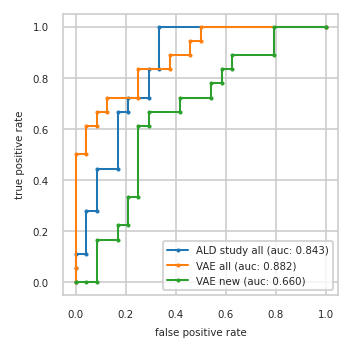

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.111   0.000 0.500   0.083 0.000
3          0.042 0.111   0.042 0.500   0.083 0.167
4          0.042 0.278   0.042 0.611   0.167 0.167
5          0.083 0.278   0.083 0.611   0.167 0.222
6          0.083 0.444   0.083 0.667   0.208 0.222
7          0.167 0.444   0.125 0.667   0.208 0.333
8          0.167 0.667   0.125 0.722   0.250 0.333
9          0.208 0.667   0.250 0.722   0.250 0.611
10         0.208 0.722   0.250 0.833   0.292 0.611
11         0.292 0.722   0.375 0.833   0.292 0.667
12         0.292 0.833   0.375 0.889   0.417 0.667
13         0.333 0.833   0.458 0.889   0.417 0.722
14         0.333 1.000   0.458 0.944   0.542 0.722
15         1.000 1.000   0.500 0.944   0.542 0.778
16           NaN   NaN   0.500 1.000   0.583 0.778
17           NaN   NaN   1.000 1.000   0.583 0.833
18           NaN   NaN     NaN   NaN   0.625 0.833
19           NaN   NaN     NaN   NaN   0.625 0.889
20           NaN   NaN     NaN   NaN   0.792 0.889
21           NaN   NaN     NaN   NaN   0.792 1.000
22           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,P31321
1,A0A0B4J1V0,Q8NFY4;Q8NFY4-6,E9PK25;G3V1A4;P23528
2,Q15782;Q15782-6,H0YMB1;Q96TC7;Q96TC7-2,O95841
3,P00740;P00740-2,P61981,A0A075B7B8
4,P61981,Q9Y2T3;Q9Y2T3-3,Q14894
5,P04075,P51688,Q96GD0
6,None,P04075,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,None,P14174,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6
8,None,P63104,P51674;P51674-2;P51674-3


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


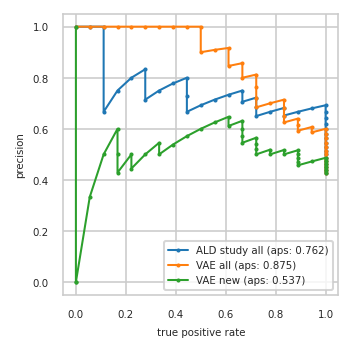

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.581 1.000     0.581 1.000     0.516 0.889
12         0.600 1.000     0.600 1.000     0.500 0.833
13         0.621 1.000     0.586 0.944     0.517 0.833
14         0.643 1.000     0.607 0.944     0.500 0.778
15         0.667 1.000     0.593 0.889     0.519 0.778
16         0.692 1.000     0.615 0.889     0.500 0.722
17         0.680 0.944     0.640 0.889     0.520 0.722
18         0.667 0.889     0.625 0.833     0.542 0.722
19         0.652 0.833     0.652 0.833     0.565 0.722
20         0.682 0.833     0.682 0.833     0.545 0.667
21         0.667 0.778     0.714 0.833     0.571 0.667
22         0.650 0.722     0.700 0.778     0.600 0.667
23         0.684 0.722     0.684 0.722     0.632 0.667
24         0.722 0.722     0.722 0.722     0.611 0.611
25         0.706 0.667     0.765 0.722     0.647 0.611
26         0.750 0.667     0.812 0.722     0.625 0.556
27         0.733 0.611     0.800 0.667     0.600 0.500
28         0.714 0.556     0.857 0.667     0.571 0.444
29         0.692 0.500     0.846 0.611     0.538 0.389
30         0.667 0.444     0.917 0.611     0.500 0.333
31         0.727 0.444     0.909 0.556     0.545 0.333
32         0.800 0.444     0.900 0.500     0.500 0.278
33         0.778 0.389     1.000 0.500     0.444 0.222
34         0.750 0.333     1.000 0.444     0.500 0.222
35         0.714 0.278     1.000 0.389     0.429 0.167
36         0.833 0.278     1.000 0.333     0.500 0.167
37         0.800 0.222     1.000 0.278     0.600 0.167
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.000 0.000
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


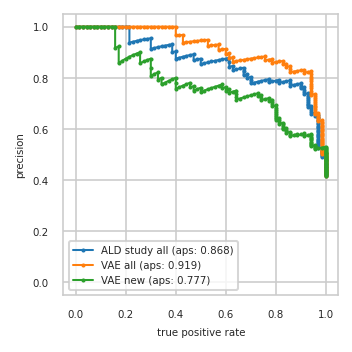

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


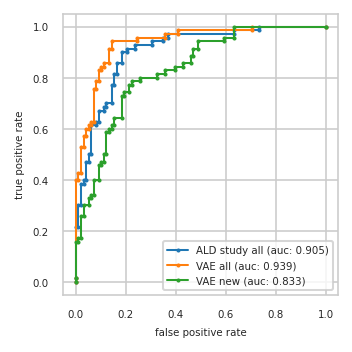

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}